<a href="https://colab.research.google.com/github/Manojkumaryadla-ymk/Brain-Tumor-Detection/blob/master/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://github.com/DeepranjanG/Brain_Tumor_Detection/tree/main/brain_tumor_dataset)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
Root = "/content/drive/MyDrive/Brain_Tumor_Detection"
os.chdir(Root)

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
import cv2

In [5]:
data = '/content/drive/MyDrive/Brain_Tumor_Detection/brain_tumor_dataset/'
No_brain_tumor = '/content/drive/MyDrive/Brain_Tumor_Detection/brain_tumor_dataset/no/'
Yes_brain_tumor = '/content/drive/MyDrive/Brain_Tumor_Detection/brain_tumor_dataset/yes/'

In [6]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [7]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Brain_Tumor_Detection/b...,No
1,/content/drive/MyDrive/Brain_Tumor_Detection/b...,No
2,/content/drive/MyDrive/Brain_Tumor_Detection/b...,No
3,/content/drive/MyDrive/Brain_Tumor_Detection/b...,No
4,/content/drive/MyDrive/Brain_Tumor_Detection/b...,No


In [8]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


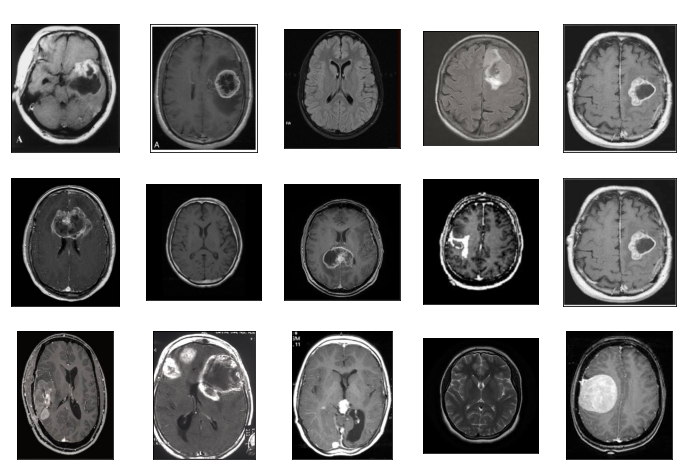

In [9]:
#visualize brain tumor images
import random
conf = random.uniform(95,98)

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


Let's start the modelling task.

The ImageDataGenerator from keras is awesome.
It lets you augment your images in real-time while your model is still training! 
You can apply any random transformations on each training image as it is passed to the model. 
This will not only make your model robust but will also save up on the overhead memory!


We will apply the Image Data Generator on training with various parameters, but we won't apply the same parameters on testin. Why?
Because we want the test images as it is, we don't want biasedness,
also if we fit it we will be applying
the model only on these test images only, it can't predict new images if fed into model
because new images will not be augmented this way.

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

print(train_datagen)
print(test_datagen)

Now fit them to get the images from directory (name of the images are given in dataframe) with augmentation

In [12]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
print(train_gen)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
print(val_gen)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)
print(test_gen)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [13]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

Our base model is InceptionResNetV2, new readers are encouraged to see the architecture of this particular model

In [14]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
print(x)
x = keras.layers.GlobalAveragePooling2D()(x)
print(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
print(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
print(x)
model = keras.Model(inputs, outputs)

print()
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='resnet50v2/post_relu/Relu:0', description="created by layer 'resnet50v2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)


Epoch 1/100
7/7 [==============================] - 36s 3s/step - loss: 0.8431 - accuracy: 0.5926 - val_loss: 1.0130 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 5s 654ms/step - loss: 0.7990 - accuracy: 0.5463 - val_loss: 0.8990 - val_accuracy: 0.3333
Epoch 3/100
7/7 [==============================] - 5s 666ms/step - loss: 0.7734 - accuracy: 0.5556 - val_loss: 0.7893 - val_accuracy: 0.5417
Epoch 4/100
7/7 [==============================] - 4s 567ms/step - loss: 0.7337 - accuracy: 0.5602 - val_loss: 0.8044 - val_accuracy: 0.3750
Epoch 5/100
7/7 [==============================] - 6s 837ms/step - loss: 0.7242 - accuracy: 0.5926 - val_loss: 0.7847 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 4s 610ms/step - loss: 0.7267 - accuracy: 0.5694 - val_loss: 0.8194 - val_accuracy: 0.3750
Epoch 7/100
7/7 [==============================] - 5s 749ms/step - loss: 0.7290 - accuracy: 0.5556 - val_loss: 0.7387 - val_accuracy: 0.4583
Epoch 8/100
7/7

In [16]:
model.save("/content/drive/MyDrive/Brain_Tumor_Detection/Tumor_classifier_model.h5")

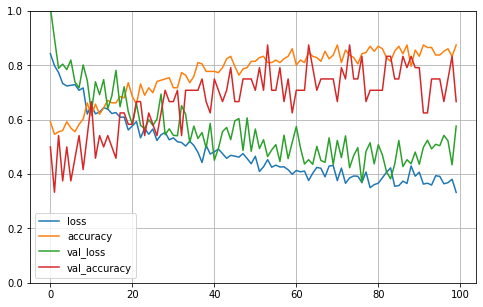

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Evaluating the model**

0
95.2393419069731% confidence
[[0.97886604]]
1
Brain Tumor Detected



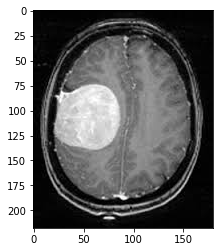

In [30]:
from matplotlib.pyplot import imshow
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Brain_Tumor_Detection/brain_tumor_dataset/yes/Y1.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
#classification = np.where(input_data == np.amax(input_data))[1][0]
#result = pred.argmax()
#print(result)
#classification = np.where(input_data == np.amax(input_data))[1][0]
#print(classification)
print(str(conf)+"% confidence")
imshow(image)
if pred>=0.5:
  print(pred)
  print("1")
  print("Brain Tumor Detected")
  print()
else:
  print(pred)
  print("0")
  print("Brain Tumor not Detected")
  print()


In [19]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [20]:
pred

array([[0.97886604]], dtype=float32)